# Using Qiskit for finance

As we will see, Qiskit provides a powerfull set of tools to implement previously described processes into a quantum computer. It is a tricky task but for sure we will see that it will only require calling to simple functions to create our circuits and obtain the results.

## Price distribution

We will start by creating the model of the price distribution previously discussed for assets in our dataset.

In [3]:
import json

data = None
with open("binance-data.json", "r") as jsonfile:
    data = json.load(jsonfile)

data[0]

{'Asset': 'ETHBTC', 'Close': 0.067077, 'Stddev': 0.00754239492210189}

As in the previous case we will construct a log-normal random distribution but in this case using the means provided by a quantum computer: quantum states. We need to setup a number of discrete points into which encode this distribution (truncated at the ends). Formaly this would be expressed as the action that takes our initial state on every quantum computer ($|0\rangle_n$) into our desired distirbution:

$$
|\psi\rangle_n = \sum_{0}^{2 -1} \sqrt{p_i}|i\rangle_n,
$$

where $p_i$ is the probability associated to the truncated distribution and $i$ is the mapping between our discrete bins:

$$
\{0,\dots,2^n-1\} \in i \rightarrow{} \frac{\text{high} - \text{low}}{2^n-1}*i + \text{low}.
$$

Here, $high$ and $low$ represent the truncation limit of the distribution.

The number of qubits we are going to use directly affect the numerical precision of our results, so it is important that we use enought resources.

In [4]:
nqubits = 5

In particular, given the low values of our assets we might require a scaling factor so, we will need to take that into consideration at the time of reading the results.

In [5]:
# Price scaling
scale = 100
S = float(data[0]["Close"]) * scale # initial spot price (scaled)

In [6]:
import numpy as np

# parameters
vol = 0.6  # volatility of 60%
inter = 0.02  # interest rate of 2% per annum
T = 40 / 365  # 1 tenth of a year for maturity

# resulting log-normal distribution
mu = (inter - 0.5 * vol**2) * T + np.log(S)
sigma = vol * np.sqrt(T)
mean = np.exp(mu + sigma**2 / 2)
variance = (np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2)
stddev = np.sqrt(variance)

# truncation values from previous calculations
low = np.maximum(0, mean - 3 * stddev)
high = scale

With that we can load the lognormal distribution into our circuit.

In [12]:
from qiskit_finance.circuit.library import LogNormalDistribution

# construct A operator for QAE composing the uncertainty model and the objective
dist_circ = LogNormalDistribution(nqubits, mu=mu, sigma=stddev**2, bounds=(low, high))

In [13]:
# plot probability distribution
x = dist_circ.values / scale
y = dist_circ.probabilities

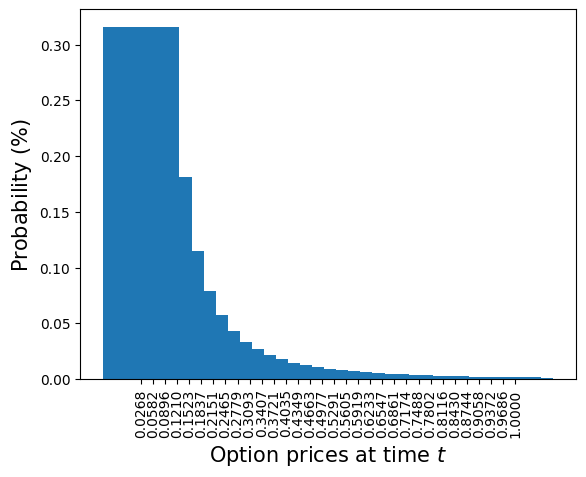

In [14]:
import matplotlib.pyplot as plt

plt.bar(x, y, width=0.2)
plt.xticks(x, rotation=90)

plt.xlabel("Option prices at time $t$", size=15)
plt.ylabel("Probability ($\%$)", size=15)
plt.show()

This lognormal distribution is nothing but the circuit containig the amplitudes encoded four our particular case. If we decompose it enough it can be clearly seen.

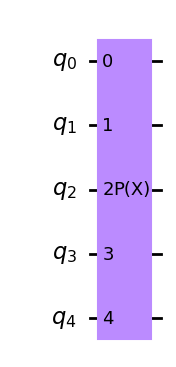

In [15]:
dist_circ.draw('mpl', fold=120)

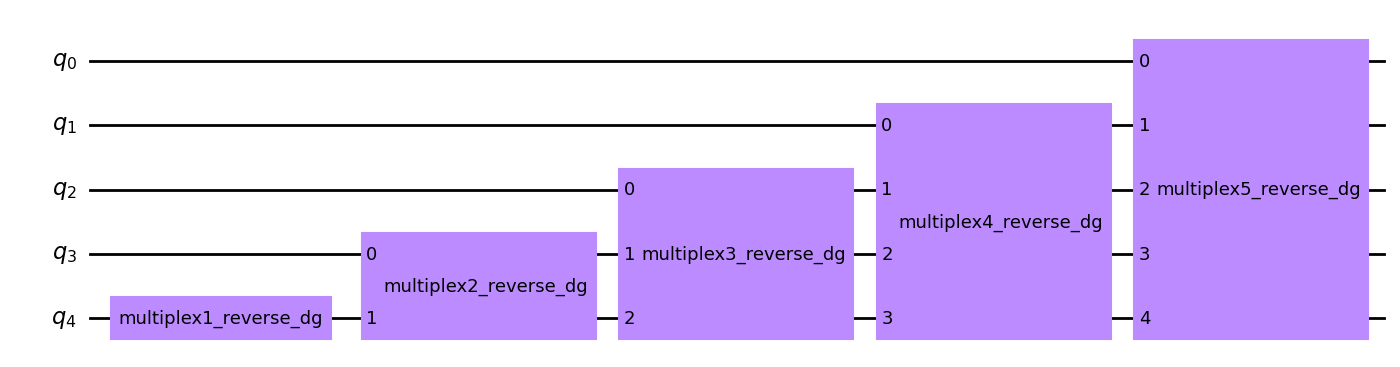

In [16]:
dist_circ.decompose().draw('mpl', fold=120)

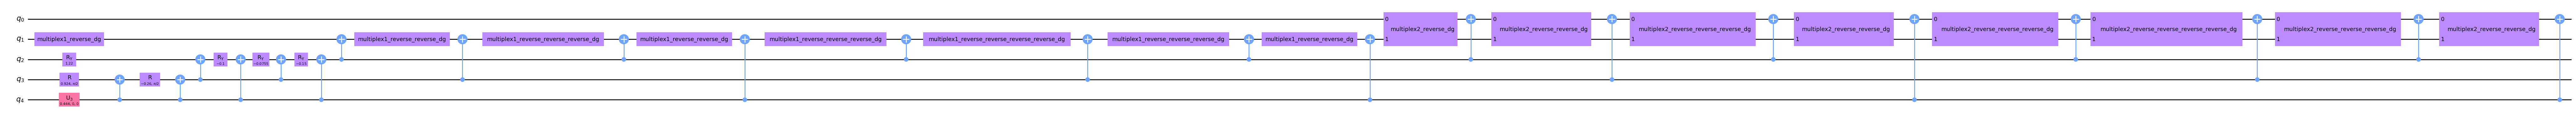

In [17]:
dist_circ.decompose().decompose().decompose().decompose().draw('mpl', fold=150)

Once our target distribution is encoded we can continue working within the quantum realm and add additional processes to our circuit. For example, we can embed the payoff function after the distribution encoding.

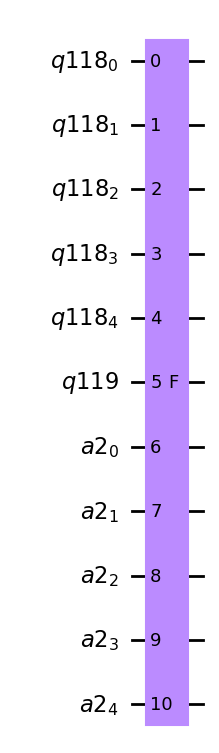

In [19]:
from qiskit.circuit.library import LinearAmplitudeFunction

# set the strike price (low << strike << high)
strike = S*1.05

# and function parameters
slopes = [0, 1]
offsets = [0, 0]

call_option = LinearAmplitudeFunction(
    nqubits,
    slopes,
    offsets,
    domain=(low, high),
    image=(0, high - strike),
    breakpoints=[low, strike],
    rescaling_factor=0.05,
)

call_option.draw('mpl')

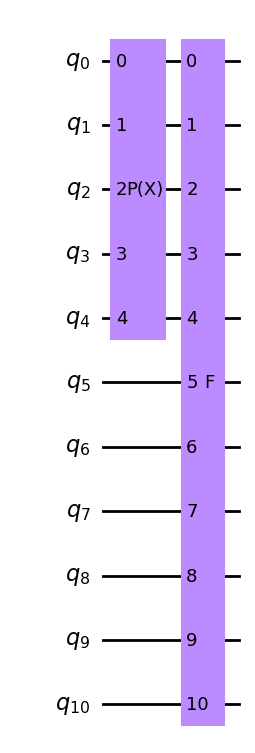

In [20]:
from qiskit import QuantumCircuit

total_qubits = call_option.num_qubits

europe_call = QuantumCircuit(total_qubits)
europe_call.append(dist_circ, range(nqubits))
europe_call.append(call_option, range(total_qubits))

# draw the circuit
europe_call.draw('mpl')

By invoking the iterative amplitude estimation routine, we can then request the resulting payoff so that we can have both an estimated value and confidence interval associated to it.

In [21]:
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.algorithms import IterativeAmplitudeEstimation, EstimationProblem

# set target precision and confidence level
epsilon = 0.01
alpha = 0.05

qi = QuantumInstance(Aer.get_backend("aer_simulator"), shots=100)
problem = EstimationProblem(
    state_preparation=europe_call,
    objective_qubits=[nqubits],
    post_processing=call_option.post_processing,
)
# construct amplitude estimation
ae = IterativeAmplitudeEstimation(epsilon, alpha=alpha, quantum_instance=qi)
result = ae.estimate(problem)

In [22]:
conf_int = np.array(result.confidence_interval_processed)
print("Estimated value:    \t%.4f" % (result.estimation_processed / scale))
print("Confidence interval:\t[%.4f, %.4f]" % tuple(conf_int/scale))

Estimated value:    	0.0859
Confidence interval:	[0.0459, 0.1259]


Qiskit offers the whole process already bundled for simplicity. Once we have build the initial state holding the distribution we could simply ask for it to be used by the _EuropeanCallPricing_ class.

In [23]:
from qiskit_finance.applications.estimation import EuropeanCallPricing

european_call_pricing = EuropeanCallPricing(
    num_state_qubits=nqubits,
    strike_price=strike,
    rescaling_factor=0.05,
    bounds=(low, high),
    uncertainty_model=dist_circ,
)

In [24]:
# Try changing target precision and confidence level
epsilon = 0.01
alpha = 0.05

qi = QuantumInstance(Aer.get_backend("aer_simulator"), shots=100)
problem = european_call_pricing.to_estimation_problem()

# construct amplitude estimation
ae = IterativeAmplitudeEstimation(epsilon, alpha=alpha, quantum_instance=qi)
result = ae.estimate(problem)

conf_int = np.array(result.confidence_interval_processed)
print("Estimated value:    \t%.4f" % (european_call_pricing.interpret(result)/scale))
print("Confidence interval:\t[%.4f, %.4f]" % tuple(conf_int/scale))

Estimated value:    	0.0947
Confidence interval:	[0.0650, 0.1245]
